In [5]:
import os
import argparse
from tqdm import tqdm
import anndata as ad
import scanpy as sc

import torch
from torch_geometric.utils.convert import from_networkx

from dhg import Hypergraph

import sys
import os
sys.path.append(os.path.abspath("/Users/joaofelipe/Yale/Hypergraph Wavelets/4_Code/hypergraph-wavelets"))

from src.hypergraphs.featurizers import get_hyperedge_features
from src.models.hsn_pyg import HSN
from src.utils.hypergraph_utils import HGDataset
from src.graphs.builder import return_graph_data

from src.utils.plot import get_hyperedge_pos_df, compute_enlarged_hulls, plot_hulls

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
from phate.cluster import kmeans
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc

import phate
import os


import seaborn as sns
from matplotlib.colors import ListedColormap

In [ ]:
patient_name = 'R1C2'
DATA_DIR = '../data/MIBI'
dataset_name =f'{patient_name}.h5ad'

FEATURE_DIR = '../data/processed/wavelet_features/1_hop/'
save_end = '_neighborhood_feat.pt'

REPORT_DIR = os.path.join('../reports',f'{dataset_name.split(".")[0]}')
os.makedirs(REPORT_DIR, exist_ok=True)

In [6]:
######################################
# LOAD IN DATA AND PREPARE MODEL
######################################
print(DATA_DIR + dataset_name)
adata = ad.read_h5ad(os.path.join(DATA_DIR, dataset_name))


data = return_graph_data(adata)
k_hop = 1

original_dataset = [data]
to_hg_func = lambda g: Hypergraph.from_graph_kHop(g, k_hop) # what should k be? 3?
dataset = HGDataset(original_dataset, to_hg_func)

../data/interim/MIBIR1C2.h5ad


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../data/interim/MIBI/R1C2.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
adata

AnnData object with n_obs × n_vars = 722 × 29
    obs: 'label', 'response_binary', 'response_multi', 'age_at_dx_tertile', 'dx_stage', 'gross_dx_stage'
    uns: 'log1p'
    obsm: 'spatial'

In [ ]:
coordinates = adata.obsm['spatial']
coordinates = coordinates - coordinates.min(axis=0)
xmax, ymax = coordinates.max(axis=0)
eidf = get_hyperedge_pos_df(dataset[0], coordinates)
enh = compute_enlarged_hulls(eidf)
X_cmbn = adata[:,:].X.toarray()

## Tissue spatially organized

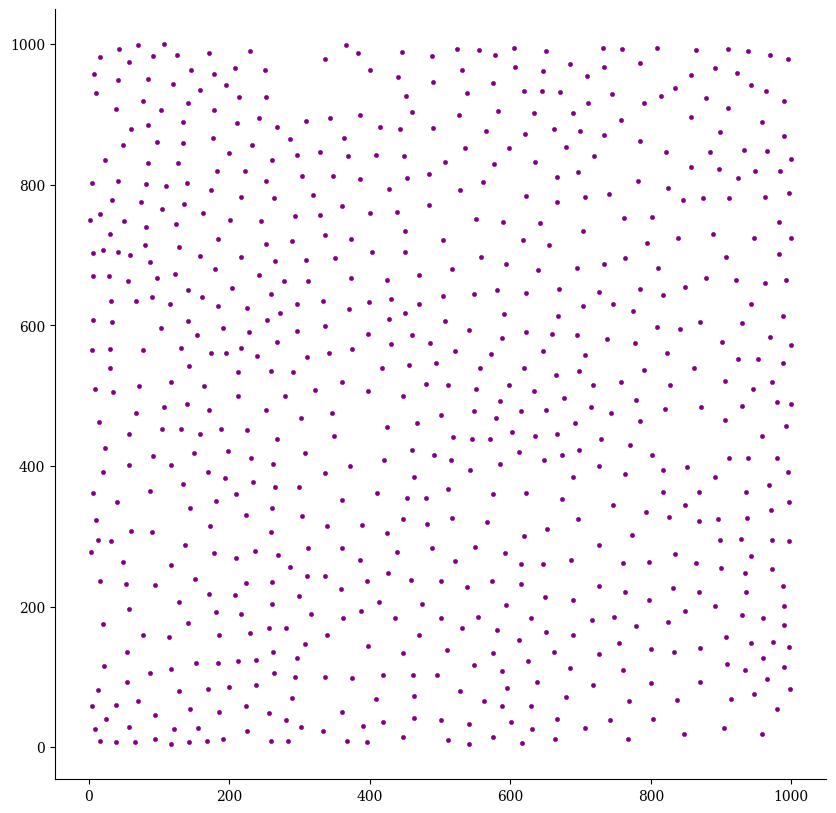

In [ ]:
fig =  plt.figure(figsize=(10,10))
plt.scatter(adata.obsm['spatial'][:,0],
            adata.obsm['spatial'][:,1],
            s=10,
            c= 'purple',
            linewidths=0.3,
            )

ax = fig.get_axes()
ax[0].set_aspect('equal')
# plt.axis(False)

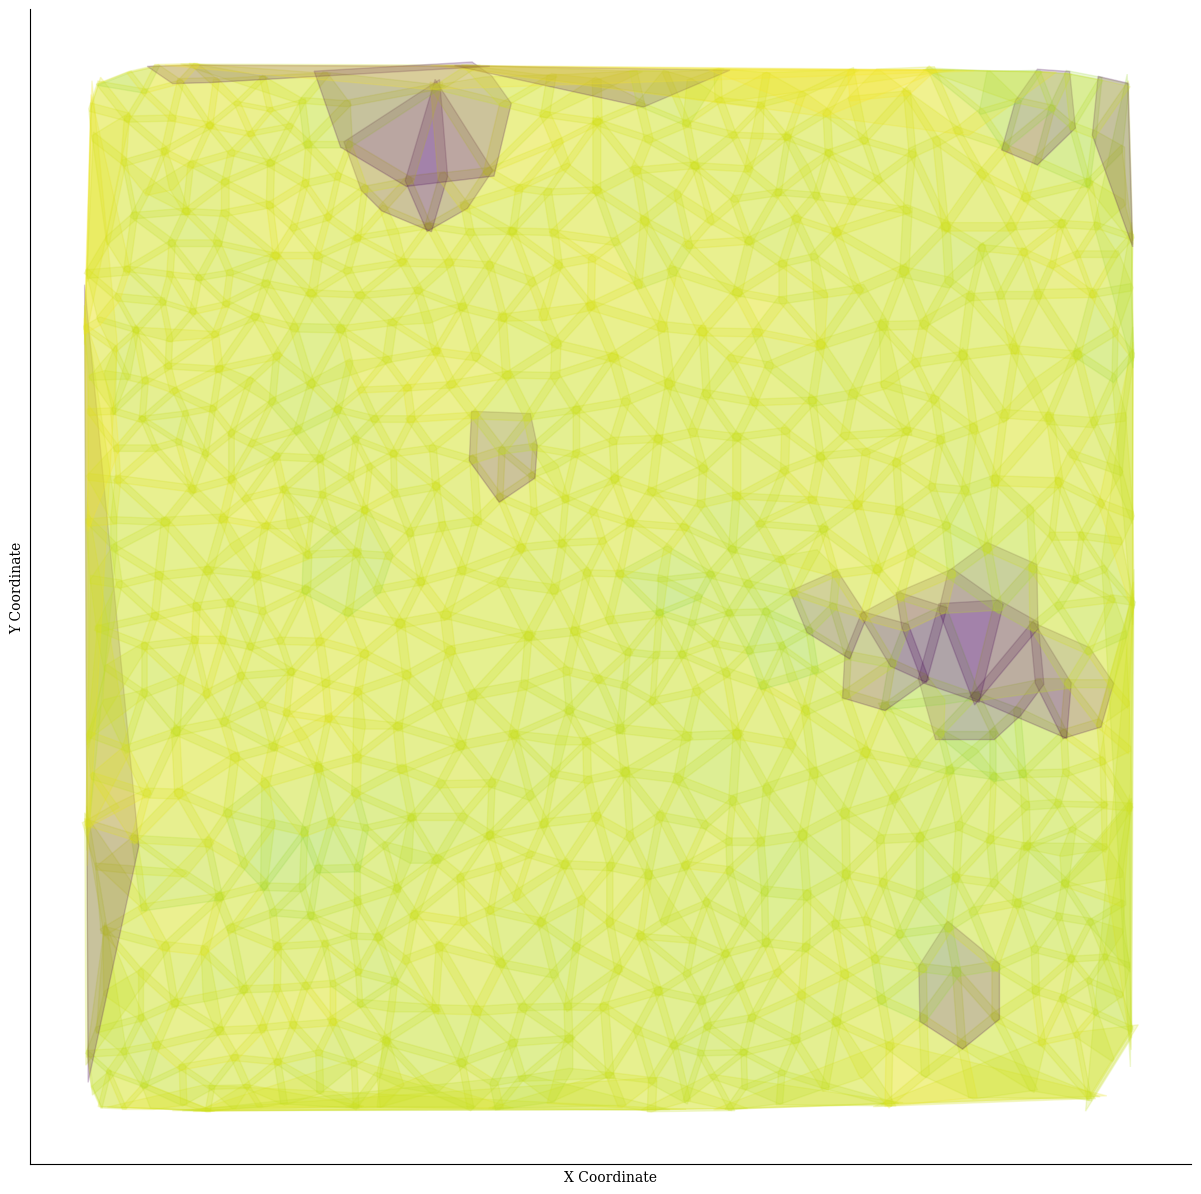

In [ ]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
ax = plot_hulls(enh, X_cmbn[:, 0], alpha=0.2, ax=ax,show_cbar=False)
ax.set_aspect('equal')
plt.show()

In [ ]:
FEATURE_DIR = '../data/processed/wavelet_features/1_hop/'

features_file = os.path.join(FEATURE_DIR, dataset_name)

normalize_features = True
phate_dim = 3
phate_knn = 5
datasets = os.listdir(FEATURE_DIR)


print(dataset_name)

hyperedge_feat = torch.load(os.path.join(FEATURE_DIR, dataset_name.split('.')[0] + '_neighborhood_feat.pt'), weights_only=True)
# hyperedge_feat = torch.load('/vast/palmer/pi/krishnaswamy_smita/jcr222/hypergraphs/wavelet_features_3_hop/wavelet_features_3_hopH20.33.001.Cx28.MTG.02.007.1.01.03.h5ad_neighborhood_feat.pt', weights_only=True)

# UNDERE HERE IS GRAPH CHANGE THIS
# hyperedge_feat = torch.load('/vast/palmer/pi/krishnaswamy_smita/xingzhi/THING/graph_wavelet_features_1hop_Truect/H20.33.001.Cx28.MTG.02.007.1.01.03.h5ad_hyperedge_feat.pt', weights_only=True)

# convert to numpy and set nans to 0
hyperedge_feat = hyperedge_feat.detach().numpy()
hyperedge_feat = np.nan_to_num(hyperedge_feat)


for h in hyperedge_feat:
    if (np.isnan(h).any()):
        print('TRUE')
    if (np.isnan(h).any()):
        print('TRUE')

# if normalize_features:
#     hyperedge_feat = (hyperedge_feat - np.mean(hyperedge_feat, axis=0)) / np.std(hyperedge_feat, axis=0)
#     hyperedge_feat = np.nan_to_num(hyperedge_feat)
phate_op = phate.PHATE(n_components=phate_dim, knn=phate_knn)

R1C2.h5ad


In [ ]:
phate_coords = phate_op.fit_transform(hyperedge_feat)

Calculating PHATE...
  Running PHATE on 722 observations and 305 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.07 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 0.50 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...


/Users/joaofelipe/miniconda3/envs/hypergraph-new/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 6.00 seconds.
Calculated PHATE in 6.70 seconds.


In [ ]:
k_clusters = 5
hyperedge_clusters = phate.cluster.kmeans(phate_op, k=k_clusters)

/Users/joaofelipe/miniconda3/envs/hypergraph-new/lib/python3.9/site-packages/phate/cluster.py:57: FutureWarning: k is deprecated. Please use n_clusters in future.
  warnings.warn(
/Users/joaofelipe/miniconda3/envs/hypergraph-new/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/joaofelipe/miniconda3/envs/hypergraph-new/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


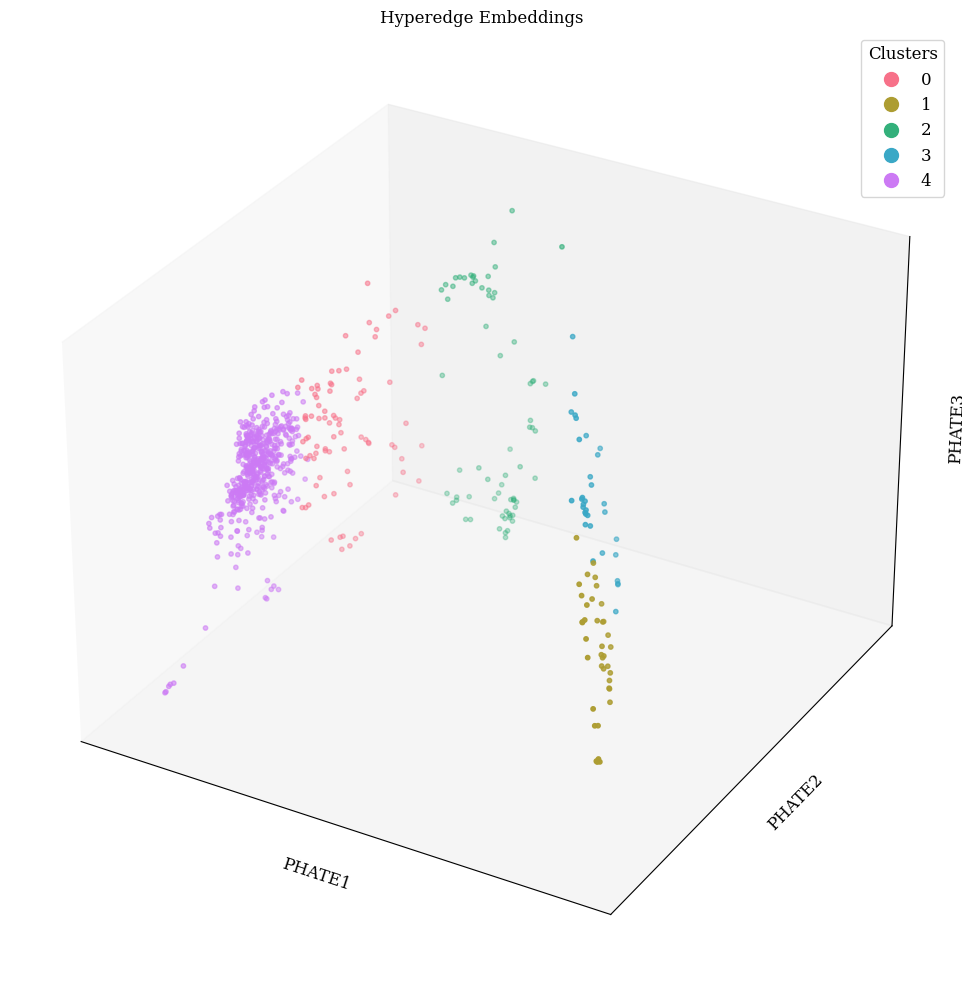

In [ ]:
import scprep
import seaborn as sns

axs = scprep.plot.scatter3d(phate_coords, 
                            c=hyperedge_clusters, 
                            cmap=sns.husl_palette(k_clusters), 
                            s=10,
                            figsize=(15,10), 
                            ticks=None, 
                            label_prefix='PHATE',
                            legend_anchor=(1,1), 
                            legend_title='Clusters',
                            fontsize=12, 
                            title='Hyperedge Embeddings')


In [ ]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.husl_palette(k_clusters))

/var/folders/1r/l8_zwkvx7_g7b632hf_1517c0000gn/T/ipykernel_27207/3458815374.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(plt.Rectangle((0, 0), 1, 1, color=color, edgecolor='k'))


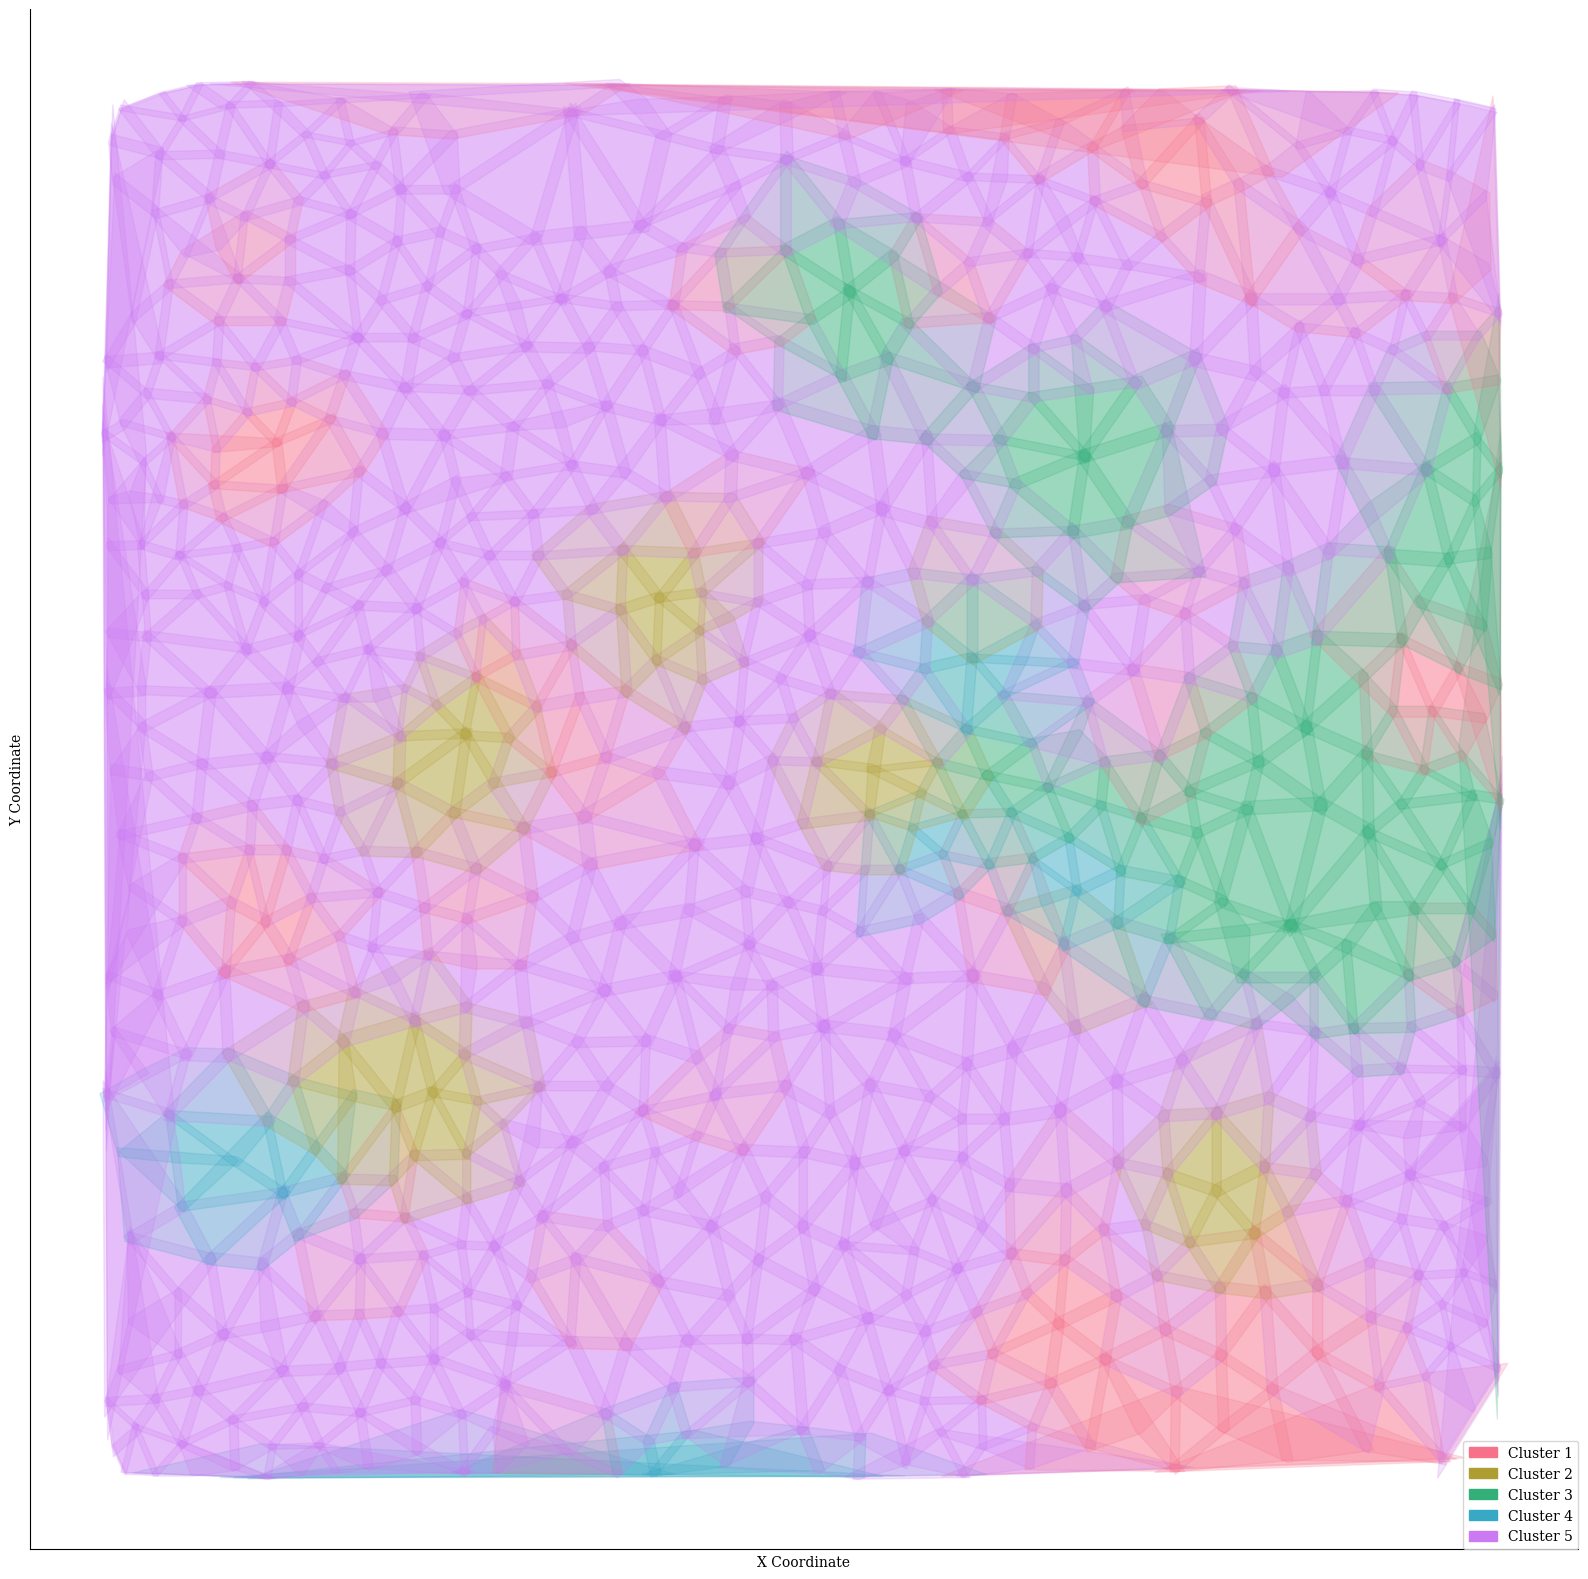

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot()
ax = plot_hulls(enh, 
                hyperedge_clusters, 
                alpha=0.2, 
                ax=ax,
                colormap=cmap,
                show_cbar=False)

ax.set_aspect('equal')

color_palette = {f'Cluster {i+1}': cmap(i) for i in range(k_clusters)}

# Create custom legend handles
handles = []
labels = []
for label,color in color_palette.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color, edgecolor='k'))
    labels.append(label)
plt.legend(handles, labels, bbox_to_anchor=None, loc='best', borderaxespad=0.)

plt.savefig(os.path.join(REPORT_DIR,f'all_hypegraphs.png'), bbox_inches='tight')

plt.show()



# BY DX STAGE

In [ ]:
def get_hyperedge_positions(hgdataset,coordinates):
    ei = hgdataset.edge_index
    eidf = pd.DataFrame(ei.T.numpy(), columns=['node_idx', 'he_idx'])
    eidf[['x', 'y']] = coordinates[eidf['node_idx'].values, :]
    return eidf

def get_hyperedge_feature(eidf, feature_serie, feature_name):
    eidf[feature_name] = feature_serie[eidf['node_idx'].values].to_numpy()
    return eidf


def group_features(df, feature_name, agg_func="max", factor=0.1):
    features = []

    display(df)
    for _, group in df.groupby('he_idx'):
        cell_grouped_feature = getattr(group[feature_name], agg_func)()
        features.append(cell_grouped_feature)
    
    return features

In [ ]:
hyperedge_df = pd.DataFrame(hyperedge_feat)
hyperedge_df['cluster'] = hyperedge_clusters

eidf = get_hyperedge_positions(dataset[0], coordinates)

# gene_list =['Podoplanin','CD4']
gene_list = adata.var_names.to_list()
gene_list = ['CD11b', 'CD11c', 'CD14', 'CD163', 'CD20', 'CD3', 'CD4',
       'CD31', 'CD68', 'CD8', 'FOXP3', 'IDO-1', 'Ki-67', 'LAG3', 'PD-1', 'PD-L1', 'Podoplanin',
       'SMA', 
    #    'SOX10', 
       'TIM-3', 
    #    'Vimentin'
       ]

for gene_id in gene_list:
    gene_expr_df = pd.Series(adata[:, gene_id].X.flatten(), index=adata.obs_names, name=gene_id)
    ei_subclass_df = get_hyperedge_feature(eidf, gene_expr_df,gene_id)

grouped_he_classes = group_features(ei_subclass_df,gene_id,agg_func="mean")

node_idx  he_idx    x    y  CD11b     CD11c      CD14  CD163  CD20  CD3  \
0            0       0   37    3    0.0  0.000000  0.000000    0.0   0.0  0.0   
1            1       0  116    0    0.0  0.000000  0.000000    0.0   0.0  0.0   
2            8       0   15    4    0.0  0.010199  0.000000    0.0   0.0  0.0   
3           10       0   64    3    0.0  0.000000  0.000000    0.0   0.0  0.0   
4           26       0   56   24    0.0  0.000000  0.000000    0.0   0.0  0.0   
...        ...     ...  ...  ...    ...       ...       ...    ...   ...  ...   
4991       710     721  604  991    0.0  0.000000  0.237897    0.0   0.0  0.0   
4992       713     721  522  989    0.0  0.000000  0.000000    0.0   0.0  0.0   
4993       716     721  807  991    0.0  0.000000  0.000000    0.0   0.0  0.0   
4994       719     721  105  996    0.0  0.000000  0.000000    0.0   0.0  0.0   
4995       721     721  365  995    0.0  0.000000  0.000000    0.0   0.0  0.0   

      ...       CD8     FOXP3     IDO-1     Ki-67      LAG3      PD-1  PD-L1  \
0     ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   
1     ...  0.000000  0.816998  1.245427  6.734134  0.000000  0.271283    0.0   
2     ...  2.681922  0.000000  0.000000  6.988063  0.000000  0.100033    0.0   
3     ...  0.692556  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   
4     ...  0.000000  0.000000  0.000000  0.000000  2.639168  0.000000    0.0   
...   ...       ...       ...       ...       ...       ...       ...    ...   
4991  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   
4992  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.799498    0.0   
4993  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   
4994  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   
4995  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   

      Podoplanin  SMA  TIM-3  
0            0.0  0.0    0.0  
1            0.0  0.0    0.0  
2            0.0  0.0    0.0  
3            0.0  0.0    0.0  
4            0.0  0.0    0.0  
...          ...  ...    ...  
4991         0.0  0.0    0.0  
4992         0.0  0.0    0.0  
4993         0.0  0.0    0.0  
4994         0.0  0.0    0.0  
4995         0.0  0.0    0.0  

[4996 rows x 23 columns]

In [ ]:
def get_distributions_he_df(ei_subclass_df, hyperedge_desired_cluster_df, gene_list):
    distributions_he_df = pd.DataFrame()
    for gene in gene_list:
        distributions_he_df[gene] = ei_subclass_df.groupby('he_idx')[gene].apply(lambda group: group.sum())
    desired_df = distributions_he_df[distributions_he_df.index.isin(hyperedge_desired_cluster_df.index)]

    return desired_df

In [ ]:
cmap = ListedColormap(sns.husl_palette(5))
plt.rcParams["font.family"] = 'serif'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# plt.ioff()

for plot_cluster in hyperedge_df['cluster'].unique().tolist():
    desired_cluster = hyperedge_clusters.copy()
    desired_cluster[desired_cluster != plot_cluster] = -1
    hyperedge_desired_cluster_df = hyperedge_df[hyperedge_df['cluster'] == plot_cluster]

    desired_df = get_distributions_he_df(ei_subclass_df,hyperedge_desired_cluster_df,gene_list=gene_list)


    # Calculate the sum of each column
    column_sums = desired_df.sum()

    # Plot bar chart of column sums
    plt.figure(figsize=(8, 6))
    plt.bar(column_sums.index, column_sums.values, color=cmap(plot_cluster), edgecolor='black')

    # Add labels and title
    plt.xlabel('Cell Type')
    plt.ylabel('Frequency')
    plt.title(f'Cell type distribution on cluster {plot_cluster+1}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='center')
    # Show the plot
    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(REPORT_DIR,f'cluster_{plot_cluster+1}_dist'))
    plt.close()
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111)
    cmap_two_colors = ListedColormap(['grey', cmap(plot_cluster)])
    ax = plot_hulls(enh, 
                    desired_cluster, 
                    alpha=0.2, 
                    ax=ax,
                    colormap=cmap_two_colors,
                    show_cbar=False)
    ax.set_ylabel(f'Cluster {plot_cluster+1}')
    # ax.set_xlabel()
    # plt.title(f'Cluster {plot_cluster+1}')
    ax.set_aspect('equal')
    plt.savefig(os.path.join(REPORT_DIR,f'cluster_{plot_cluster+1}_slice'))
    plt.close()



## Stacked barplot

In [ ]:
plt.rcParams["font.family"] = 'serif'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.title_fontsize'] = 14

cmap = ListedColormap(sns.mpl_palette("tab20", len(gene_list)))

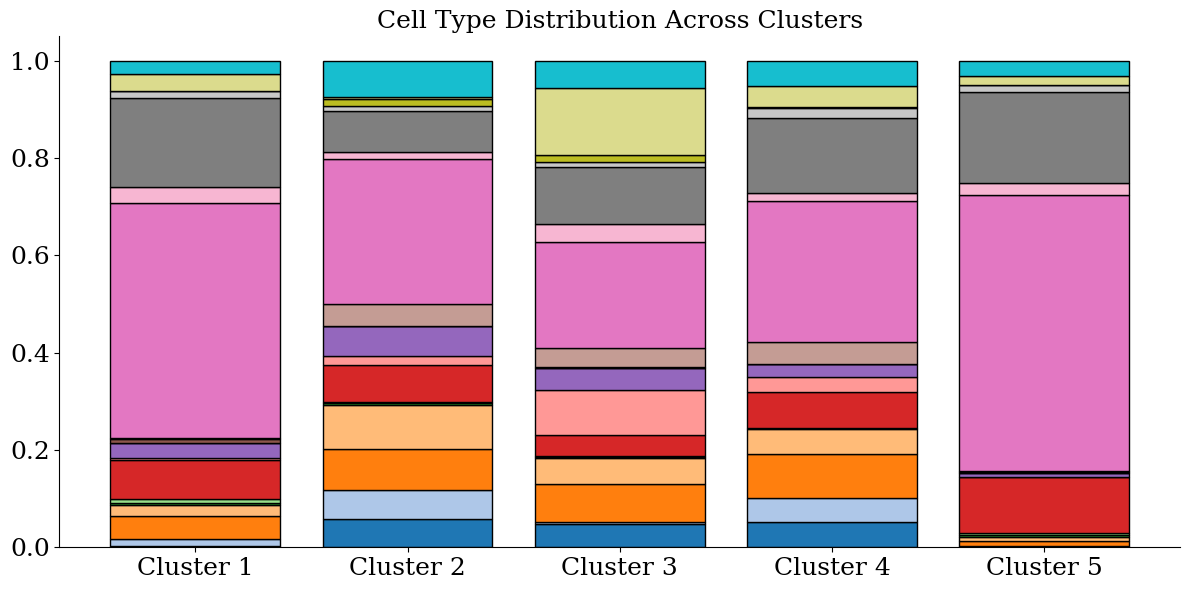

/var/folders/1r/l8_zwkvx7_g7b632hf_1517c0000gn/T/ipykernel_27207/2320712606.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color, edgecolor='k') for color in color_palette.values()]


In [ ]:
plt.close()
plt.figure(figsize=(12, 6))
# Initialize array to store cluster sums
cluster_sums = np.zeros((k_clusters, len(gene_list)))

# Calculate sums for each cluster
for plot_cluster in range(k_clusters):
    hyperedge_desired_cluster_df = hyperedge_df[hyperedge_df['cluster'] == plot_cluster]
    desired_df = get_distributions_he_df(ei_subclass_df,hyperedge_desired_cluster_df,gene_list=gene_list)
    desired_df = desired_df[desired_df.index.isin(hyperedge_desired_cluster_df.index)]
    distributions_he_df_normalized = desired_df.div(desired_df.sum(axis=0), axis=1)
    # bottom = np.zeros(len(desired_df.columns))
    # desired_df = distributions_he_df_normalized[distributions_he_df_normalized.index.isin(hyperedge_desired_cluster_df.index)]
    cluster_sums[plot_cluster] = desired_df.sum()

# Normalize cluster sums
cluster_sums = cluster_sums / cluster_sums.sum(axis=1, keepdims=True)

# Plot stacked bar chart
bottom = np.zeros(k_clusters)
for i, cell_type in enumerate(gene_list):
    plt.bar(range(k_clusters), cluster_sums[:, i], bottom=bottom, 
            color=cmap(i), edgecolor='black', 
            label=cell_type)
    bottom += cluster_sums[:, i]

# Add labels and title
plt.title('Cell Type Distribution Across Clusters',fontsize=18)

# Set x-axis ticks
plt.xticks(range(k_clusters), [f'Cluster {i+1}' for i in range(k_clusters)],fontsize=18)
plt.yticks(fontsize=18)
# Adjust layout
plt.tight_layout()

# Uncomment to save the figure
plt.savefig(os.path.join(REPORT_DIR,f'cell_type_distribution_across_clusters.png'), bbox_inches='tight')
plt.show()
plt.close()

# Create a standalone legend figure for gene_list
fig, ax = plt.subplots(figsize=(3, 3))
cmap = ListedColormap(sns.mpl_palette("tab20", len(gene_list)))
color_palette = {gene: cmap(i) for i, gene in enumerate(gene_list)}

# Create custom legend handles
handles = [plt.Rectangle((0, 0), 1, 1, color=color, edgecolor='k') for color in color_palette.values()]
labels = list(color_palette.keys())

# Add the legend to the figure
legend = ax.legend(handles, labels, loc='center', title='Genes')
ax.axis('off')

# Save the legend figure
plt.savefig(os.path.join(REPORT_DIR,'gene_legend_plot.png'), bbox_inches='tight')
plt.close()

# Single example

In [ ]:
plot_cluster = 3
desired_cluster = hyperedge_clusters.copy()
desired_cluster[desired_cluster != plot_cluster] = 0
desired_cluster.shape

(722,)

In [ ]:
hyperedge_desired_cluster_df = hyperedge_df[hyperedge_df['cluster'] == plot_cluster]
hyperedge_desired_cluster_df.shape

(33, 306)

In [ ]:
desired_df = get_distributions_he_df(ei_subclass_df,hyperedge_desired_cluster_df,gene_list=gene_list)
desired_df = desired_df[desired_df.index.isin(hyperedge_desired_cluster_df.index)]
desired_df

CD11b      CD11c       CD14      CD163      CD20       CD3  \
he_idx                                                                   
1        4.712218   5.129053   6.450049   1.025415  0.912184  0.000000   
2        4.712218   5.129053   6.450049   1.025415  0.000000  0.000000   
3        4.712218   7.219404   9.415949   1.025415  0.000000  0.000000   
5        4.651805   5.129053   6.450049   1.025415  0.000000  0.000000   
7        4.712218   5.129053   6.450049   1.025415  0.000000  0.000000   
17       4.651805   5.129053   6.450049   1.025415  0.000000  0.000000   
20       4.651805   5.129053   6.450049   1.025415  0.000000  0.000000   
28       4.651805   7.219404   9.415949   1.025415  0.000000  0.000000   
33       4.651805   5.129053   6.450049   1.025415  0.000000  0.000000   
151      6.490384   3.170523   6.751903   6.009532  0.000000  0.000000   
157      6.490384   3.170523   6.751903   6.009532  0.000000  0.000000   
162     10.669756   4.809906  12.842867  12.185526  0.000000  2.326234   
171      6.490384   3.170523   6.751903   6.520233  0.000000  0.000000   
172      6.490384   3.170523   6.751903   6.520233  0.000000  0.000000   
177      6.615604   4.809906   6.685824   6.580123  0.000000  0.000000   
189      6.490384   3.170523   6.751903   6.520233  0.000000  0.000000   
199      6.490384   3.170523   6.751903   6.520233  0.000000  0.000000   
292      5.105821   5.806688   6.880694   5.318812  0.000000  0.000000   
298      5.105821   5.806688  21.984708   8.181466  0.000000  0.000000   
302      5.105821   5.806688  21.798150   8.181466  0.000000  0.000000   
308      5.105821   5.806688  12.061892   5.318812  0.000000  0.000000   
313      4.761293   6.118493  10.671060   8.434431  0.000000  0.061056   
317      4.761293   7.353376   6.958957   5.172949  0.000000  0.061056   
320      5.105821   7.041572  27.165906   8.181466  0.000000  0.000000   
325      5.105821   5.806688  17.251981   8.181466  0.000000  0.000000   
329     11.122586  12.280912  17.569606  14.756428  0.000000  0.061056   
339     11.122586  13.833203  13.857503  15.209047  0.000000  0.061056   
409      4.869982   5.285438  10.460390   6.454323  0.000000  0.000000   
414      4.869982   5.285438   7.299528   6.454323  0.000000  0.000000   
417      4.869982   5.285438   7.299528   6.454323  0.000000  0.000000   
422      4.869982   5.285438   7.299528   6.454323  0.000000  0.000000   
439      4.869982   5.285438  10.122874   6.454323  0.000000  0.000000   
441      4.869982   5.285438   7.299528   6.454323  0.000000  0.000000   

              CD4       CD31       CD68       CD8     FOXP3     IDO-1  \
he_idx                                                                  
1        2.701668   0.000000   0.000000  0.967042  0.816998  6.053018   
2        0.733552   0.000000   0.000000  0.000000  0.816998  6.092675   
3        1.872985   0.000000   0.000000  0.000000  0.000000  4.807592   
5        7.832961   0.000000   0.000000  0.274486  0.816998  6.053018   
7       12.546301   0.000000   0.000000  0.274486  0.816998  6.053018   
17       5.912772   0.000000   0.000000  0.274486  0.000000  4.807592   
20      11.812749   0.000000   0.000000  0.000000  0.000000  4.807592   
28      12.726051   0.000000   0.000000  0.000000  0.000000  4.807592   
33      16.196414   0.000000   0.000000  0.000000  0.000000  4.807592   
151      9.370444   0.000000   0.000000  0.000000  0.000000  7.694586   
157     11.032746   0.000000   0.000000  0.000000  0.000000  7.694586   
162     13.080228   0.000000   5.467781  0.000000  0.000000  8.189538   
171      3.595707   0.000000   0.000000  0.000000  0.000000  5.141353   
172      0.159135   0.000000   0.000000  0.000000  0.000000  7.694586   
177      9.675805   0.000000   5.467781  0.000000  0.000000  8.189538   
189      5.417144   0.000000   0.000000  0.000000  0.000000  7.694586   
199      3.595707   0.000000   0.000000  0.000000  0.000000  7.353343   
292     13.726142   4.839384   1.6

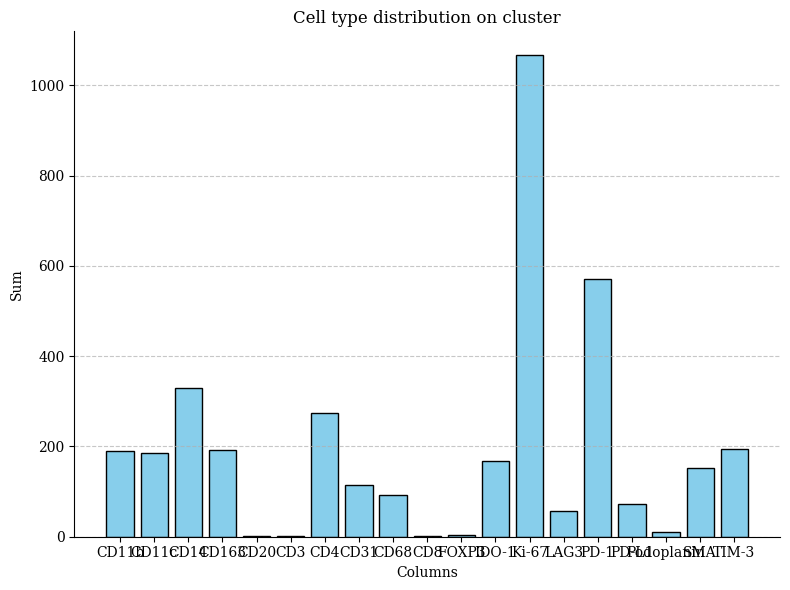

In [ ]:
# Calculate the sum of each column
column_sums = desired_df.sum()
bottom = np.zeros(len(desired_df.columns))

# Plot bar chart of column sums
plt.figure(figsize=(8, 6))

plt.bar(column_sums.index, column_sums.values, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.title('Cell type distribution on cluster')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

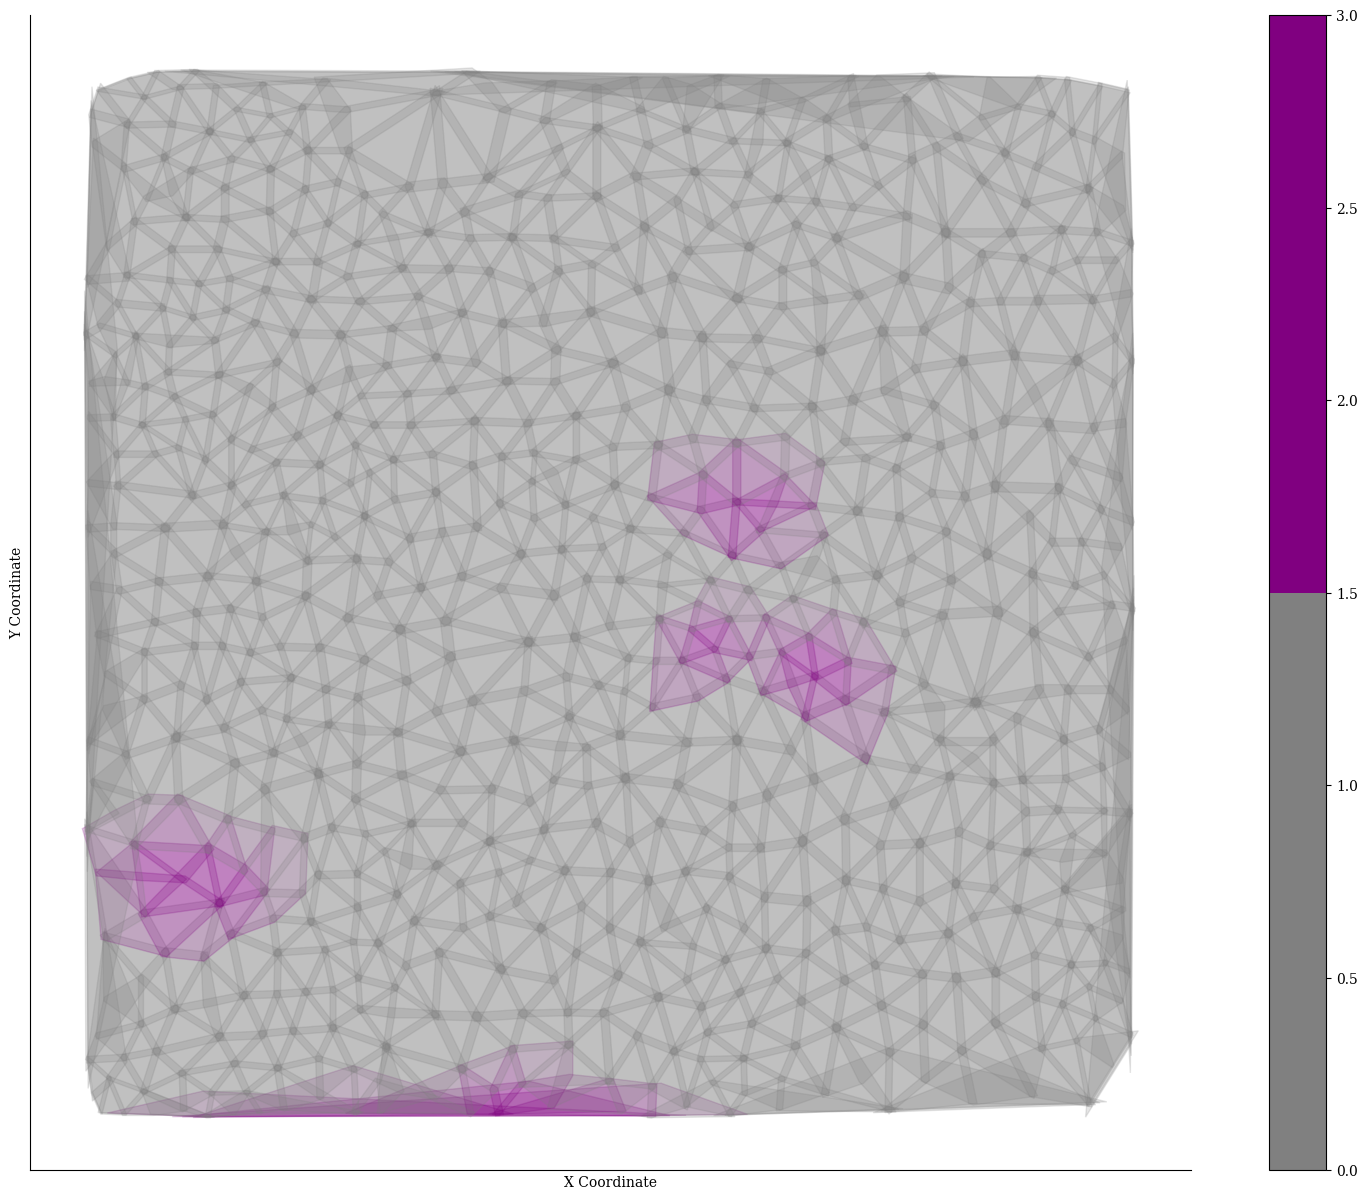

In [ ]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
cmap = ListedColormap(sns.husl_palette(len(np.unique(desired_cluster))))
cmap = ListedColormap(['grey', 'purple'])
ax = plot_hulls(enh, 
                desired_cluster, 
                alpha=0.2, 
                ax=ax,
                colormap=cmap,
                show_cbar=True)
ax.set_aspect('equal')
plt.show()